In [1]:
import pandas as pd
import numpy as np
import itertools
import random
import ast
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, wilcoxon, friedmanchisquare, kendalltau, pearsonr
from matplotlib import animation
from mpl_toolkits import mplot3d
from scipy.spatial import distance
from pyxdameraulevenshtein import damerau_levenshtein_distance

pd.set_option('display.max_rows', 500)

### Prepare Data

In [11]:
# read data, skip row that can't be clustered

df = pd.read_csv('automatica_task_environments_clustered.csv', header=0,
                skiprows=[2,3,4,8,9,10,11,12,13,17,18,19,20,21,22,23,24,27,28,29,30,
                         32,33,34,35,38,39,40,42,44,45,46,49,50,51,52,54,55,57,58,59,
                         62,65,68,70,71,73,74,76,77,78,79,80,82])

### Define functions for prediction

In [7]:
def predict_sequence(objects, coordinates, start_coordinates, c, k, dimension=[3,]):
    ''' Predicts sequence based on required objects, object coordinates, start coordinates of subject,
        parameters (c+k) and dimensionality.
        Input: Objects, object coordinates, start coordinates, c, k, dimension
        Output: Sequence of objects as str
    '''
    prediction = []
    possible_items = dict.fromkeys(objects, 0) # generate dict from object list
    coord_index = 0
    start_coords = start_coordinates
    coords = coordinates
    new_coords = {}
    new_start_coords = []
    
    if dimension[0] == 3: # no changes if 3D
        new_coords = coords
        new_start_coords = start_coords
        
    elif dimension[0] == 2: # 2D: remove obsolete coordinate
        if dimension[1] == 'xy':
            new_coords = {key: value[:-1] for key, value in coords.items()}
            new_start_coords = [x[:-1] for x in start_coords]
                
        elif dimension[1] == 'xz':
            new_start_coords = [[x[0], x[-1]] for x in start_coords]
            
            for key, value in coords.items():
                new_value = (value[0], value[-1])
                new_coords[key] = new_value
        
        elif dimension[1] == 'yz':
            new_coords = {key: value[1:] for key, value in coords.items()}
            new_start_coords = [x[1:] for x in start_coords]
                
    elif dimension[0] == 1: # 1D: choose appropriate coordinate
        if dimension[1] == 'x':
            new_coords = {key: value[0] for key, value in coords.items()}
            new_start_coords = [x[0] for x in start_coords]
        
        elif dimension[1] == 'y':
            new_coords = {key: value[1] for key, value in coords.items()}
            new_start_coords = [x[1] for x in start_coords]
        
        elif dimension[1] == 'z':
            new_coords = {key: value[2] for key, value in coords.items()}
            new_start_coords = [x[2] for x in start_coords]
    
    while bool(possible_items) == True: # while dict not empty
        for obj in possible_items.keys():
            possible_items[obj] = ((distance.euclidean(
                                new_start_coords[coord_index], 
                                new_coords[obj])
                                ) ** k[obj]) * c[obj]
        #print(possible_items)                      
        minval = min(possible_items.values())
        minval = [k for k, v in possible_items.items() if v == minval]
        minval = random.choice(minval) # choose prediction randomly if multiple items have same cost
        prediction.append(minval)
        del possible_items[minval]
        coord_index += 1
        
    return prediction

In [8]:
def get_median(objects, coordinates, start_coordinates, c, k, dimension, sequence,n=10):
    ''' Returns average edit distance (Damerau-Levenshtein) for 100 trials of sequence prediction.
    '''
    edit_list = []

    for x in range(0,n):
        result = ''.join(predict_sequence(objects, coordinates, start_coordinates, c, k, dimension))
        dl = damerau_levenshtein_distance(sequence,result)
        edit_list.append(dl)
    
    #avg = np.mean(edit_list)
    median = np.median(edit_list)
    return median

In [36]:
def get_avg_editdist(data, dimensions=[[1,'x'],[1,'y'],[1,'z'],[2,'xy'],[2,'xz'],[2,'yz'],[3,'xyz']],n=10):
    ''' Calculates average edit distance for all combinations of parameters (c, k, dimension).
        Input: Dataframe with objects, coordinates, start coordinates, object categories
        Output: Dataframe with edit distance results (col name: parameters used)
    '''
    results = pd.DataFrame()
        
    for row in range(0,len(data)):
        objects = list(data.at[row,'objects'].split(','))
        strong_k = list(data.at[row,'strong_k'].split(','))
        mid_k = list(data.at[row,'mid_k'].split(','))
        #food_k = list(data.at[row,'food_k'].split(','))
        food_k = []
        coordinates = {key: ast.literal_eval(value) for key, value in (elem.split(': ') for elem in data.at[row,'coordinates'].split(';'))}
        #print(coordinates)
        start_coordinates = list(ast.literal_eval(data.at[row, 'start_coordinates']))
        sequence = str(data.at[row,'sequence'])
        c1 = {obj: 1.2 for obj in objects}
        k1 = {obj: 1.0 for obj in objects}
        
        #for k2 in np.arange(1.1,2.0,0.1):
            #k_food = round(k2,2)
            #k1 = {obj: k_food if obj in food_k else 1.0 for obj in objects}
        
        for k in np.arange(0,0.9,0.1):
            k_strong = round(k,2)
            k_mid = round(k + 0.1,2)
            k1 = {obj: k_strong if obj in strong_k else k_mid if obj in mid_k else round(k1[obj],2) for obj in objects}
            
                #for c in np.arange(1.0,2.0,0.1):
                #    c = round(c, 1)
                #    c1 = {obj: 1.2 for obj in objects}
                
            for dim in dimensions:                
                # get average edit distance
                median = get_median(objects, coordinates, start_coordinates, c1, k1, dim, sequence, n)
                median = median / len(sequence)
                #params = 'c: ' + str(c) + '; k: ' + str(k_strong) + ',' + str(k_mid) + ',' + str(k_food) + '; ' + str(dim[1])
                params = 'c: 1.2' + '; k: ' + str(k_strong) + ',' + str(k_mid) + '; ' + str(dim[1])
                results.at[row,params] = median
                        
        results.at[row,'sequence'] = sequence
                    
    return results

### Calculate edit distances, create df

In [48]:
# 15 min for n = 30
# 20 min for n = 40
%time results_new = get_avg_editdist(df,n=100)

CPU times: user 1min 1s, sys: 80 ms, total: 1min 1s
Wall time: 1min 1s


In [49]:
results_new

,"c: 1.2; k: 0.0,0.1; x","c: 1.2; k: 0.0,0.1; y","c: 1.2; k: 0.0,0.1; z","c: 1.2; k: 0.0,0.1; xy","c: 1.2; k: 0.0,0.1; xz","c: 1.2; k: 0.0,0.1; yz","c: 1.2; k: 0.0,0.1; xyz","c: 1.2; k: 0.1,0.2; x","c: 1.2; k: 0.1,0.2; y","c: 1.2; k: 0.1,0.2; z",...,"c: 1.2; k: 0.7,0.8; yz","c: 1.2; k: 0.7,0.8; xyz","c: 1.2; k: 0.8,0.9; x","c: 1.2; k: 0.8,0.9; y","c: 1.2; k: 0.8,0.9; z","c: 1.2; k: 0.8,0.9; xy","c: 1.2; k: 0.8,0.9; xz","c: 1.2; k: 0.8,0.9; yz","c: 1.2; k: 0.8,0.9; xyz",sequence
0,0.666667,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333,0.666667,0.833333,0.833333,...,0.833333,0.666667,0.666667,0.833333,0.833333,0.666667,0.833333,0.833333,0.666667,pocgkr
1,0.888889,0.777778,0.888889,0.666667,0.888889,0.777778,0.666667,0.888889,0.666667,0.888889,...,0.888889,1.000000,0.777778,0.888889,0.666667,1.000000,0.777778,0.888889,1.000000,wptgkfsoc
2,0.800000,0.600000,0.400000,0.400000,0.800000,0.600000,0.400000,0.800000,0.600000,0.400000,...,0.800000,0.800000,0.800000,0.800000,0.200000,0.800000,0.800000,0.800000,0.800000,pwfkg
3,0.666667,0.833333,1.000000,0.666667,0.833333,0.666667,0.666667,0.666667,0.833333,1.000000,...,0.833333,0.666667,0.500000,0.833333,1.000000,0.666667,0.666667,0.833333,0.666667,powcer
4,0.666667,0.833333,0.833333,0.666667,0.666667,0.833333,0.666667,0.666667,0.833333,0.833333,...,0.833333,0.666667,0.666667,0.833333,0.833333,0.666667,0.666667,0.833333,0.666667,ocwgrk
5,0.833333,0.833333,0.666667,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333,0.666667,...,1.000000,1.000000,0.833333,1.000000,0.666667,1.000000,0.833333,1.000000,1.000000,wpgsfk
6,1.000000,0.666667,0.666667,0.666667,1.000000,0.666667,0.666667,1.000000,0.666667,0.666667,...,0.833333,0.833333,0.833333,0.833333,0.500000,0.833333,0.833333,0.833333,0.833333,pwofsg
7,0.625000,0.875000,0.750000,0.875000,0.500000,0.750000,0.875000,0.625000,0.875000,0.750000,...,0.875000,0.875000,0.500000,0.875000,0.500000,0.875000,0.375000,0.875000,0.875000,cwpfksor
8,0.750000,0.875000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.875000,0.750000,...,0.625000,0.875000,0.750000,0.625000,0.750000,0.750000,0.750000,0.625000,0.750000,pwfksorc
9,0.600000,0.800000,0.400000,0.800000,0.600000,0.800000,0.800000,0.600000,0.600000,0.400000,...,0.800000,0.800000,0.800000,0.800000,0.600000,0.800000,0.400000,0.800000,0.800000,pwfkt


### Get lowest error, compare edit distances

In [18]:
def get_lowest_error(results):
    ''' Returns lowest error in dataframe and index of lowest error.
    '''
    for col in list(results):
        if col != 'sequence':
            results.loc['mean',col] = results[col].mean()
            #results.loc['median',col] = results[col].median()
    lowest = min(results.loc['mean'])
    mean = list(results.loc['mean'])
    
    return lowest, results.columns[(results.loc['mean'] == lowest)], mean, results

In [50]:
lowest, lowest_idx, list_mean, results_mean = get_lowest_error(results_new)
lowest, lowest_idx

(0.6441570881226053, Index(['c: 1.2; k: 0.5,0.6; z'], dtype='object'))

In [25]:
np.nanmean(list_mean), np.nanmedian(list_mean)

(0.5027614766757182, 0.5042328042328043)

In [40]:
# Compare avg edit distance for xy and xyz
list_xy = []
list_xyz = []

for col in results_mean:
    if col != 'sequence' and col.split(';')[2].strip() == 'xy':
        list_xy.append(results_mean.at['mean',col])
    elif col != 'sequence' and col.split(';')[2].strip() == 'xyz':
        list_xyz.append(results_mean.at['mean',col])
        
avg_xy = np.mean(list_xy)
med_xy = np.median(list_xy)
std_xy = np.std(list_xy)
print('Average xy: ' + str(avg_xy)  + ', stdev: ' + str(std_xy) + ', median: ' + str(med_xy))
        
avg_xyz = np.mean(list_xyz)
med_xyz = np.median(list_xyz)
std_xyz = np.std(list_xyz)
print('Average xyz: ' + str(avg_xyz) + ', stdev: ' + str(std_xyz) + ', median: ' + str(med_xyz))

Average xy: 0.7173766952502586, stdev: 0.053555671897587, median: 0.7201559934318557
Average xyz: 0.7082162622392507, stdev: 0.050484493581742874, median: 0.6820060207991243


In [41]:
# Compare avg edit distances for x, y, z
list_x = []
list_y = []
list_z = []
list_xz = []
list_yz = []

for col in results_mean:
    if col != 'sequence' and col.split(';')[2].strip() == 'x':
        list_x.append(results_mean.at['mean',col])
    elif col != 'sequence' and col.split(';')[2].strip() == 'y':
        list_y.append(results_mean.at['mean',col])
    elif col != 'sequence' and col.split(';')[2].strip() == 'z':
        list_z.append(results_mean.at['mean',col])
    elif col != 'sequence' and col.split(';')[2].strip() == 'xz':
        list_xz.append(results_mean.at['mean',col])
    elif col != 'sequence' and col.split(';')[2].strip() == 'yz':
        list_yz.append(results_mean.at['mean',col])

avg_xz = np.mean(list_xz)
avg_yz = np.mean(list_yz)
        
avg_x = np.mean(list_x)
lowest_x = min(list_x)
print('Average x: ' + str(avg_x) + ', min: ' + str(lowest_x)) 
        
avg_y = np.mean(list_y)
lowest_y = min(list_y)
print('Average y: ' + str(avg_y) + ', min: ' + str(lowest_y)) 
        
avg_z = np.mean(list_z)
lowest_z = min(list_z)
print('Average z: ' + str(avg_z) + ', min: ' + str(lowest_z)) 

print('Average xz: ' + str(avg_xz)) 
print('Average yz: ' + str(avg_yz)) 

Average x: 0.7645274584929758, min: 0.7286672140120417
Average y: 0.7574028461959499, min: 0.7017378215654079
Average z: 0.6995773277382473, min: 0.6441570881226053
Average xz: 0.7077358146323663
Average yz: 0.7449020859940402


### Statistical analysis

In [22]:
# Compare all error predictions for dimensions
stat, p = friedmanchisquare(list_x,list_y,list_z,list_xy,list_xz,list_yz,list_xyz)
print('Friedman: stat = %.3f, p = % 10.3E' % (stat, p))

Friedman: stat = 1784.160, p =  0.000E+00


In [32]:
# 2D vs 3D median
stat, p = wilcoxon(list_z, list_xyz, zero_method='wilcox')
print('Wilcoxon: W = %.3f, p = %.5f' % (stat, p))

Wilcoxon: W = 117675.000, p = 0.00000


### Plots for dataframe

In [56]:
# Define input for plots

c = [float(x[3:6]) for x in results_new.columns.tolist() if x != 'sequence']
#k = [float(x[11:14]) for x in results_new.columns.tolist() if x != 'sequence']
k_strong = [float(x[11:14]) for x in results_new.columns.tolist() if x != 'sequence']
k_mid = [float(x[15:18]) for x in results_new.columns.tolist() if x != 'sequence']
dim = [x.strip() for x in results_new.columns[:-1].str.split(';').str[2]]
median = [x for x in results_mean.loc['mean'].tolist() if pd.notnull(x)]

In [62]:
%matplotlib qt

cm = ['red','blue','green','magenta','cyan','orange','grey']
dim_num = [0 if x=='x' else 1 if x=='y' else 2 if x=='z' else 3 if x=='xy' else 4 if x=='xz' else 5 if x=='yz' else 6 for x in dim]

cmap = matplotlib.colors.ListedColormap(cm)

ticks = ['x', 'y', 'z', 'xy', 'xz', 'yz', 'xyz']
norm = matplotlib.colors.BoundaryNorm(ticks, cmap.N)

# create figure, 3d grid, set background to white
fig2 = plt.figure(figsize=(12,8))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.w_xaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax2.w_yaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax2.w_zaxis.set_pane_color((1.0,1.0,1.0,1.0))

# create plot w/ median edit distance
#img = ax2.scatter(c, k, median, alpha=0.5, s=38, c=dim_num, cmap=cmap)
img = ax2.scatter(k_strong, k_mid, median, alpha=0.5, s=38, c=dim_num, cmap=cmap)

# plot horizontal plane for baseline
#xx, yy = np.meshgrid(np.linspace(1,1.9), np.linspace(0,0.9))
xx, yy = np.meshgrid(np.linspace(0,0.9), np.linspace(0,0.9))
#yy = np.meshgrid(range(2), range(2))
zz = xx * 0 + 0.706
ax2.plot_surface(xx, yy, zz, alpha=0.5)

# set labels
ax2.set_ylabel('strong k', fontsize=20, labelpad=10)
ax2.set_xlabel('mid k', fontsize=20, labelpad=10)
ax2.set_zlabel('normalized edit distance', fontsize=20, labelpad=7)
#plt.title('Average edit distance (1 step)', fontsize=24)

# create colorbar
cb = plt.colorbar(img, cax = fig2.add_axes([0.9,0.3,0.03,0.4]))
cb.ax.set_yticklabels(ticks, fontsize=16)
plt.show()

/home/zauri/files/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


### Check for sequences worse than baseline

In [51]:
# get sequences from best model where performance worse than baseline
results_new['c: 1.2; k: 0.5,0.6; z'].loc[results_new['c: 1.2; k: 0.5,0.6; z'] >= 0.706]

0     0.833333
1     0.888889
3     1.000000
4     0.833333
8     0.750000
10    0.857143
11    0.800000
12    0.833333
17    0.714286
18    1.000000
19    0.857143
21    0.750000
23    0.714286
24    0.800000
27    0.857143
28    0.750000
Name: c: 1.2; k: 0.5,0.6; z, dtype: float64

In [52]:
# create list of sequences where performance worse than baseline
rows_sequences = []
rows_sequences.append(results_new['sequence'].iloc[0])
rows_sequences.append(results_new['sequence'].iloc[1])
rows_sequences.append(results_new['sequence'].iloc[3])
rows_sequences.append(results_new['sequence'].iloc[4])
rows_sequences.append(results_new['sequence'].iloc[8])
rows_sequences.append(results_new['sequence'].iloc[10])
rows_sequences.append(results_new['sequence'].iloc[11])
rows_sequences.append(results_new['sequence'].iloc[12])
rows_sequences.append(results_new['sequence'].iloc[17])
rows_sequences.append(results_new['sequence'].iloc[18])
rows_sequences.append(results_new['sequence'].iloc[19])
rows_sequences.append(results_new['sequence'].iloc[21])
rows_sequences.append(results_new['sequence'].iloc[23])
rows_sequences.append(results_new['sequence'].iloc[24])
rows_sequences.append(results_new['sequence'].iloc[27])
rows_sequences.append(results_new['sequence'].iloc[28])
rows_sequences

['pocgkr',
 'wptgkfsoc',
 'powcer',
 'ocwgrk',
 'pwfksorc',
 'powcgre',
 'perkscwgtf',
 'pocwkf',
 'pocsfkw',
 'pocgwrkfs',
 'tgcwpro',
 'opwg',
 'ptwgfks',
 'pockr',
 'pwgerks',
 'pwfksocr']

### Run model for only 2D/3D

In [28]:
df2 = pd.read_csv('automatica_task_environments_clustered.csv', header=0,
                skiprows=[2,3,4,8,9,10,11,12,13,17,18,19,20,21,22,23,24,27,28,29,30,
                         32,33,34,35,38,39,40,42,44,45,46,49,50,51,52,54,55,57,58,59,
                         62,65,68,70,71,73,74,76,77,78,79,80,82])

In [29]:
# 6-7 min for dimensions = xy, xyz (n=40)
# n=50: 8 min
# n=100: 13-16 min
%time results_2D3D = get_avg_editdist(df2, dimensions=[[2,'xy'],[3,'xyz']],n=100)

CPU times: user 26min 27s, sys: 184 ms, total: 26min 27s
Wall time: 26min 27s


In [30]:
results_2D3D

,"c: 1.0; k: 0.0,0.1,1.1; xy","c: 1.0; k: 0.0,0.1,1.1; xyz","c: 1.1; k: 0.0,0.1,1.1; xy","c: 1.1; k: 0.0,0.1,1.1; xyz","c: 1.2; k: 0.0,0.1,1.1; xy","c: 1.2; k: 0.0,0.1,1.1; xyz","c: 1.3; k: 0.0,0.1,1.1; xy","c: 1.3; k: 0.0,0.1,1.1; xyz","c: 1.4; k: 0.0,0.1,1.1; xy","c: 1.4; k: 0.0,0.1,1.1; xyz",...,"c: 1.5; k: 0.8,0.9,1.9; xyz","c: 1.6; k: 0.8,0.9,1.9; xy","c: 1.6; k: 0.8,0.9,1.9; xyz","c: 1.7; k: 0.8,0.9,1.9; xy","c: 1.7; k: 0.8,0.9,1.9; xyz","c: 1.8; k: 0.8,0.9,1.9; xy","c: 1.8; k: 0.8,0.9,1.9; xyz","c: 1.9; k: 0.8,0.9,1.9; xy","c: 1.9; k: 0.8,0.9,1.9; xyz",sequence
0,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333,...,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,pocgkr
1,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,wptgkfsoc
2,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,...,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,pwfkg
3,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,...,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,powcer
4,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,...,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,ocwgrk
5,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,wpgsfk
6,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,...,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333,pwofsg
7,0.875000,0.875000,0.875000,0.875000,0.875000,0.875000,0.875000,0.875000,0.875000,0.875000,...,0.875000,0.875000,0.875000,0.875000,0.875000,0.875000,0.875000,0.875000,0.875000,cwpfksor
8,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,...,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,pwfksorc
9,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,...,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,pwfkt


In [31]:
lowest2, lowest_idx2, list_mean2, results_mean2 = get_lowest_error(results_2D3D)
lowest2, lowest_idx2

(0.6498357963875206,
 Index(['c: 1.0; k: 0.2,0.3,1.1; xy', 'c: 1.0; k: 0.2,0.3,1.1; xyz',
        'c: 1.1; k: 0.2,0.3,1.1; xy', 'c: 1.1; k: 0.2,0.3,1.1; xyz',
        'c: 1.2; k: 0.2,0.3,1.1; xy', 'c: 1.2; k: 0.2,0.3,1.1; xyz',
        'c: 1.3; k: 0.2,0.3,1.1; xy', 'c: 1.3; k: 0.2,0.3,1.1; xyz',
        'c: 1.4; k: 0.2,0.3,1.1; xy', 'c: 1.4; k: 0.2,0.3,1.1; xyz',
        ...
        'c: 1.0; k: 0.3,0.4,1.9; xyz', 'c: 1.1; k: 0.3,0.4,1.9; xyz',
        'c: 1.2; k: 0.3,0.4,1.9; xyz', 'c: 1.3; k: 0.3,0.4,1.9; xyz',
        'c: 1.4; k: 0.3,0.4,1.9; xyz', 'c: 1.5; k: 0.3,0.4,1.9; xyz',
        'c: 1.6; k: 0.3,0.4,1.9; xyz', 'c: 1.7; k: 0.3,0.4,1.9; xyz',
        'c: 1.8; k: 0.3,0.4,1.9; xyz', 'c: 1.9; k: 0.3,0.4,1.9; xyz'],
       dtype='object', length=270))

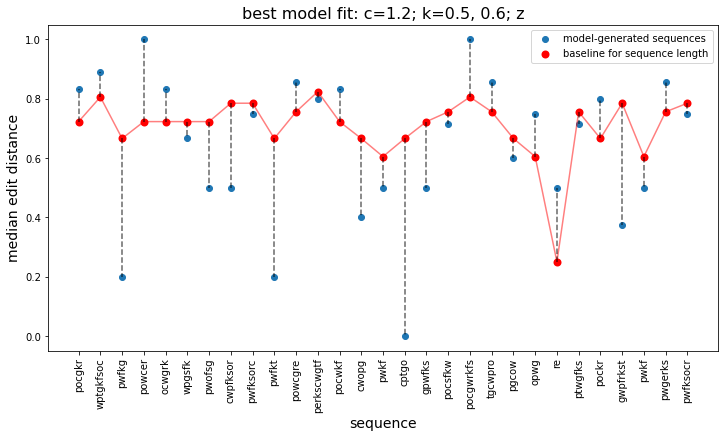

In [55]:
%matplotlib inline

error_individual = df['error']
seqs = results_mean['sequence'][:-1].values
res = results_new['c: 1.2; k: 0.5,0.6; z'][:-1].values
x = [x for x in range (0,len(seqs))]

plt.figure(figsize=(12,6))
plt.scatter(x, res, marker='o', label='model-generated sequences')
plt.scatter(x, error_individual, c='red', marker='o', linewidth=2, label='baseline for sequence length')
plt.plot(x, error_individual, c='red', alpha=0.5)
plt.plot((x,x),(error_individual,res), '--', c='black', alpha=0.6)


plt.title('best model fit: c=1.2; k=0.5, 0.6; z', fontsize=16)
plt.xticks(x, seqs, rotation=90)
plt.ylabel('median edit distance', fontsize=14)
plt.xlabel('sequence', fontsize=14)
plt.legend()

#plt.savefig('plot_median_editdist_individualerrors_diff.png', bbox_inches='tight')
plt.show()

In [147]:
# Define input for 2D/3D plots

c2 = [float(x[3:6]) for x in results_new.columns.tolist() if x != 'sequence']
k2 = [float(x[11:14]) for x in results_new.columns.tolist() if x != 'sequence']
dim2 = [x.strip() for x in results_new.columns[:-1].str.split(';').str[2]]
median2 = [x for x in results_mean.loc['mean'].tolist() if pd.notnull(x)]

In [157]:
# Plot scatterplots for xy, xyz only

%matplotlib qt

cm2 = ['blue','green']
dim_num2 = [0 if x=='xy' else 1 for x in dim]

cmap2 = matplotlib.colors.ListedColormap(cm2)

ticks2 = ['xy', 'xyz']
norm = matplotlib.colors.BoundaryNorm(ticks2, cmap2.N)

# create figure, 3d grid, set background to white
fig3 = plt.figure(figsize=(12,8))
ax3 = fig3.add_subplot(111, projection='3d')
ax3.w_xaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax3.w_yaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax3.w_zaxis.set_pane_color((1.0,1.0,1.0,1.0))

# create plot w/ median edit distance
img2 = ax3.scatter(c2, k2, median2, alpha=0.5, s=38, c=dim_num2, cmap=cmap2)

# plot horizontal plane for baseline
xx, yy = np.meshgrid(np.linspace(1,1.9), np.linspace(0,0.9))
zz = xx * 0 + 0.603
ax3.plot_surface(xx, yy, zz, alpha=1.0)

# set labels
ax3.set_ylabel('parameter k', fontsize=20, labelpad=10)
ax3.set_xlabel('parameter c', fontsize=20, labelpad=10)
ax3.set_zlabel('normalized edit distance', fontsize=20, labelpad=7)

cb = plt.colorbar(img2, cax = fig3.add_axes([0.9,0.3,0.03,0.1]))
cb.ax.set_yticklabels(ticks2, fontsize=16)

plt.show()

In [43]:
line = 'p: (0.008034,0.957082,0.6890539999999999);q: (-0.185,0.928,0.48103500000000005);c: (-0.525007,0.923283,0.438);g: (-0.595001,1.233,0.468999);k: (-0.030993,0.7334229999999999,0.530651);u: (-0.606068,0.743321,0.524829)'

In [44]:
test = {key: ast.literal_eval(value) for key, value in (elem.split(': ') for elem in line.split(';'))}